In [1]:
import sklearn
print(sklearn.__version__)

1.3.2


In [72]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

#### 

#### Importando a base de dados feita com o script de coleta de dados a partir do Yahoofinance, atualmente para não pesar temos apenas 3 ativos. Mas podemos fazer todos ativos da bolsa disponível quando desejar.

In [73]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.273384,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.259526,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.252606,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.254336,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.259526,6445,ABEV3.SA


In [74]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26956 entries, 0 to 26955
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       26956 non-null  datetime64[ns]
 1   Open       26956 non-null  float64       
 2   High       26956 non-null  float64       
 3   Low        26956 non-null  float64       
 4   Close      26956 non-null  float64       
 5   Adj Close  26956 non-null  float64       
 6   Volume     26956 non-null  int64         
 7   Ticker     26956 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.6+ MB


#### Ordenando por data e ticker e pegando a diferença do dia anterior.

In [75]:
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by = ['Ticker','Date'], inplace = True)

price_data['change_in_price'] = price_data['Close'].diff()
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price
11743,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998
11744,2024-12-23,54.669998,55.230000,54.400002,54.849998,54.849998,18587900,VALE3.SA,0.230000
11745,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000
11746,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997
11747,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002


In [76]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    return np.sign(data.shift(-d) - data)



# Aplicando a suavização exponencial
alpha = 0.10
price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 20 dias
d = 30
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.273384,985,ABEV3.SA,NaN,0.520882,1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.259526,227,ABEV3.SA,-0.026404,0.518242,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.252606,1137,ABEV3.SA,-0.013185,0.514547,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.254336,606,ABEV3.SA,0.003296,0.511551,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.259526,6445,ABEV3.SA,0.009889,0.509844,1.0


In [77]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1  # Substitui os 0 por -1
    return target



# Aplicando a suavização exponencial
alpha = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 20 dias
d = 30
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.273384,985,ABEV3.SA,NaN,0.520882,1.0,0.520882,1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.259526,227,ABEV3.SA,-0.026404,0.518242,1.0,0.494478,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.252606,1137,ABEV3.SA,-0.013185,0.514547,1.0,0.481293,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.254336,606,ABEV3.SA,0.003296,0.511551,1.0,0.484589,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.259526,6445,ABEV3.SA,0.009889,0.509844,1.0,0.494478,1.0


In [78]:
# Aplicando o deslocamento de 30 linhas dentro de cada grupo de 'Ticker'
price_data['Close_30'] = price_data.groupby('Ticker')['Close'].shift(-30)
price_data['Smoothed_Close_30'] = price_data.groupby('Ticker')['Smoothed_Close'].shift(-30)

#### Tirando a diferença do 'Smoothed_Close' na virada de um tick para outro.

In [79]:
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)

price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

price_data[price_data.isna().any(axis = 1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.273384,985,ABEV3.SA,NaN,0.520882,1.0,0.520882,1.0,0.599993,0.548886
5703,2024-11-13,12.520000,12.770000,12.460000,12.730000,12.065012,30341700,ABEV3.SA,0.150000,12.707867,NaN,12.730000,NaN,NaN,NaN
5704,2024-11-14,12.690000,12.900000,12.610000,12.640000,11.979713,38027500,ABEV3.SA,-0.089999,12.701081,NaN,12.640000,NaN,NaN,NaN
5705,2024-11-18,12.480000,12.670000,12.380000,12.420000,11.771206,37251000,ABEV3.SA,-0.220000,12.672973,NaN,12.420000,NaN,NaN,NaN
5706,2024-11-19,12.450000,12.600000,12.420000,12.430000,11.780684,28564100,ABEV3.SA,0.010000,12.648675,NaN,12.430000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11743,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998,56.874140,NaN,54.619999,NaN,NaN,NaN
11744,2024-12-23,54.669998,55.230000,54.400002,54.849998,54.849998,18587900,VALE3.SA,0.230000,56.671726,NaN,54.849998,NaN,NaN,NaN
11745,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,56.505553,NaN,55.009998,NaN,NaN,NaN
11746,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,56.328998,NaN,54.740002,NaN,NaN,NaN


#### Calculando o RSI.

**Fórmula:**

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

In [80]:
# Período do indicador.
n = 14

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI
11743,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998,56.874140,NaN,54.619999,NaN,NaN,NaN,0.000000,0.849998,34.571055
11744,2024-12-23,54.669998,55.230000,54.400002,54.849998,54.849998,18587900,VALE3.SA,0.230000,56.671726,NaN,54.849998,NaN,NaN,NaN,0.000000,0.230000,37.065454
11745,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,56.505553,NaN,55.009998,NaN,NaN,NaN,0.000000,0.160000,38.934135
11746,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,56.328998,NaN,54.740002,NaN,NaN,NaN,0.269997,0.000000,36.806222
11747,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,56.151098,NaN,54.549999,NaN,NaN,NaN,0.190002,0.000000,35.242227


## Calculando o Stochastic Oscillator

**Fórmula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [81]:
n = 14
low_14, high_14 = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()
low_14 = low_14.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = n).max())

k_percent = 100 * ((price_data['Smoothed_Close'] - low_14) / (high_14 - low_14))

price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent
11743,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998,56.874140,NaN,54.619999,NaN,NaN,NaN,0.000000,0.849998,34.571055,53.330002,60.189999,51.663850
11744,2024-12-23,54.669998,55.230000,54.400002,54.849998,54.849998,18587900,VALE3.SA,0.230000,56.671726,NaN,54.849998,NaN,NaN,NaN,0.000000,0.230000,37.065454,53.330002,60.189999,48.713205
11745,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,56.505553,NaN,55.009998,NaN,NaN,NaN,0.000000,0.160000,38.934135,53.330002,60.189999,46.290860
11746,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,56.328998,NaN,54.740002,NaN,NaN,NaN,0.269997,0.000000,36.806222,53.330002,60.189999,43.717168
11747,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,56.151098,NaN,54.549999,NaN,NaN,NaN,0.190002,0.000000,35.242227,53.330002,60.189999,41.123874


## Calculando o indicador Williams %R

**Fórmula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [82]:
# Período de cálculo do indicador
n = 14

low_14, high_14 = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()

#Aplicanod a função no grupo
low_14 = low_14.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculando o indicador
r_percent = ((high_14 - price_data['Smoothed_Close']) / (high_14 - low_14)) * (- 100)


price_data['r_percent'] = r_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
11743,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998,56.874140,NaN,54.619999,NaN,NaN,NaN,0.000000,0.849998,34.571055,53.330002,60.189999,51.663850,-48.336150
11744,2024-12-23,54.669998,55.230000,54.400002,54.849998,54.849998,18587900,VALE3.SA,0.230000,56.671726,NaN,54.849998,NaN,NaN,NaN,0.000000,0.230000,37.065454,53.330002,60.189999,48.713205,-51.286795
11745,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,56.505553,NaN,55.009998,NaN,NaN,NaN,0.000000,0.160000,38.934135,53.330002,60.189999,46.290860,-53.709140
11746,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,56.328998,NaN,54.740002,NaN,NaN,NaN,0.269997,0.000000,36.806222,53.330002,60.189999,43.717168,-56.282832
11747,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,56.151098,NaN,54.549999,NaN,NaN,NaN,0.190002,0.000000,35.242227,53.330002,60.189999,41.123874,-58.876126


## Cálculo do indicador Moving Average Convergence Divergnece (MACD)

**Fórmula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$


In [83]:
# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
11743,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998,56.874140,NaN,54.619999,NaN,NaN,NaN,0.000000,0.849998,34.571055,53.330002,60.189999,51.663850,-48.336150,-0.728296,-0.615779
11744,2024-12-23,54.669998,55.230000,54.400002,54.849998,54.849998,18587900,VALE3.SA,0.230000,56.671726,NaN,54.849998,NaN,NaN,NaN,0.000000,0.230000,37.065454,53.330002,60.189999,48.713205,-51.286795,-0.776551,-0.647933
11745,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,56.505553,NaN,55.009998,NaN,NaN,NaN,0.000000,0.160000,38.934135,53.330002,60.189999,46.290860,-53.709140,-0.818763,-0.682099
11746,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,56.328998,NaN,54.740002,NaN,NaN,NaN,0.269997,0.000000,36.806222,53.330002,60.189999,43.717168,-56.282832,-0.856589,-0.716997
11747,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,56.151098,NaN,54.549999,NaN,NaN,NaN,0.190002,0.000000,35.242227,53.330002,60.189999,41.123874,-58.876126,-0.890655,-0.751729


### Cálculo do indicador Price Rate Of Change

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


In [84]:
# Período do indicador
n = 9

# Calculando o Price Rate
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = n))

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
11743,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998,56.874140,NaN,54.619999,NaN,NaN,NaN,0.000000,0.849998,34.571055,53.330002,60.189999,51.663850,-48.336150,-0.728296,-0.615779,-0.028488
11744,2024-12-23,54.669998,55.230000,54.400002,54.849998,54.849998,18587900,VALE3.SA,0.230000,56.671726,NaN,54.849998,NaN,NaN,NaN,0.000000,0.230000,37.065454,53.330002,60.189999,48.713205,-51.286795,-0.776551,-0.647933,-0.033972
11745,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,56.505553,NaN,55.009998,NaN,NaN,NaN,0.000000,0.160000,38.934135,53.330002,60.189999,46.290860,-53.709140,-0.818763,-0.682099,-0.037093
11746,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,56.328998,NaN,54.740002,NaN,NaN,NaN,0.269997,0.000000,36.806222,53.330002,60.189999,43.717168,-56.282832,-0.856589,-0.716997,-0.036864
11747,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,56.151098,NaN,54.549999,NaN,NaN,NaN,0.190002,0.000000,35.242227,53.330002,60.189999,41.123874,-58.876126,-0.890655,-0.751729,-0.035577


## Cálculo do indicador On Balance Volume

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$


In [85]:
def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)
        

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)

price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11743,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998,56.874140,NaN,54.619999,NaN,NaN,NaN,0.000000,0.849998,34.571055,53.330002,60.189999,51.663850,-48.336150,-0.728296,-0.615779,-0.028488,2646856848
11744,2024-12-23,54.669998,55.230000,54.400002,54.849998,54.849998,18587900,VALE3.SA,0.230000,56.671726,NaN,54.849998,NaN,NaN,NaN,0.000000,0.230000,37.065454,53.330002,60.189999,48.713205,-51.286795,-0.776551,-0.647933,-0.033972,2628268948
11745,2024-12-26,54.849998,55.400002,54.400002,55.009998,55.009998,13155800,VALE3.SA,0.160000,56.505553,NaN,55.009998,NaN,NaN,NaN,0.000000,0.160000,38.934135,53.330002,60.189999,46.290860,-53.709140,-0.818763,-0.682099,-0.037093,2615113148
11746,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,56.328998,NaN,54.740002,NaN,NaN,NaN,0.269997,0.000000,36.806222,53.330002,60.189999,43.717168,-56.282832,-0.856589,-0.716997,-0.036864,2598477848
11747,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,56.151098,NaN,54.549999,NaN,NaN,NaN,0.190002,0.000000,35.242227,53.330002,60.189999,41.123874,-58.876126,-0.890655,-0.751729,-0.035577,2587226948


#### Salvando antes de tirar os Nans.

In [16]:

price_data.to_parquet('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D30.parquet', index=False)

In [32]:
# price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D30.xlsx', index=False)

## Removendo Nans

In [86]:
# We need to remove all rows that have an NaN value.
print('Antes de tirar as NaN nós tinhamos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('Depois da retirada dos NaN temos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

Antes de tirar as NaN nós tinhamos 26956 linhas e 26 colunas
Depois da retirada dos NaN temos 26741 linhas e 26 colunas


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
13,2000-02-22,0.485255,0.485255,0.485255,0.485255,0.254685,75,ABEV3.SA,-0.029034,0.503659,1.0,0.485255,1.0,0.586808,0.598848,0.029034,0.000000,43.244009,0.468107,0.527474,59.884943,-40.115057,-0.001383,-0.001015,-0.012131,15246
14,2000-02-23,0.494478,0.494478,0.494478,0.494478,0.259526,455,ABEV3.SA,0.009223,0.502741,1.0,0.494478,1.0,0.606585,0.599621,0.000000,0.009223,47.299662,0.468107,0.527474,58.338476,-41.661524,-0.001503,-0.001116,-0.017330,14791
15,2000-02-24,0.487885,0.487885,0.487885,0.487885,0.256066,5005,ABEV3.SA,-0.006593,0.501255,1.0,0.487885,1.0,0.599993,0.599659,0.006593,0.000000,44.667003,0.468107,0.527474,55.836108,-44.163892,-0.001665,-0.001229,-0.022635,9786
16,2000-02-25,0.474700,0.474700,0.474700,0.474700,0.249145,3033,ABEV3.SA,-0.013185,0.498600,1.0,0.474700,1.0,0.626363,0.602329,0.013185,0.000000,39.583155,0.468107,0.527474,51.363045,-48.636955,-0.001933,-0.001373,-0.025578,6753
17,2000-02-29,0.468107,0.468107,0.468107,0.468107,0.245685,11602,ABEV3.SA,-0.006593,0.495550,1.0,0.468107,1.0,0.652734,0.607370,0.006593,0.000000,37.143972,0.468107,0.527474,46.226741,-53.773259,-0.002306,-0.001563,-0.023218,-4849


## VALIDAÇÃO

### Geral

In [87]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data['Prediction']

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.5556552962298025

Fold 2:
Accuracy for fold 2: 0.571588868940754

Fold 3:
Accuracy for fold 3: 0.5886445242369839

Fold 4:
Accuracy for fold 4: 0.6113105924596051

Fold 5:
Accuracy for fold 5: 0.6144524236983842

                precision    recall  f1-score      support  accuracy
1 Down Day       0.477283  0.541158  0.507218  1883.000000  0.555655
  Up Day         0.627747  0.566265  0.595423  2573.000000  0.555655
  accuracy       0.555655  0.555655  0.555655     0.555655  0.555655
  macro avg      0.552515  0.553711  0.551320  4456.000000  0.555655
  weighted avg   0.564164  0.555655  0.558149  4456.000000  0.555655
2 Down Day       0.525452  0.775194  0.626346  2064.000000  0.571589
  Up Day         0.671155  0.395903  0.498028  2392.000000  0.571589
  accuracy       0.571589  0.571589  0.571589     0.571589  0.571589
  macro avg      0.598303  0.585548  0.562187  4456.000000  0.571589
  weighted avg   0.603666  0.571589  0.557464  4456.000000  0.5715

In [88]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  79.89829494466049


In [89]:
import warnings

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Selecionar colunas como array NumPy
X_Cols = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction'
price_data['Prediction'] = rand_frst_clf.predict(X_Cols)

# Comparar valores e calcular a precisão
price_data['Match'] = (price_data['Prediction'] == price_data['Verify']).astype(int)
accuracy = price_data['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 79.16%


In [90]:
from datetime import timedelta

# Filtrar últimos 30 dias
last_30_days = price_data[price_data['Date'] >= price_data['Date'].max() - timedelta(days=30)]

# Selecionar colunas como array NumPy
X_Cols = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction' para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf.predict(X_Cols)

# Comparar valores e calcular a precisão
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = last_30_days['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy:.2%}")



Precisão do modelo nos últimos 30 dias: 80.00%


In [38]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl']

### AMBEV

#### Time Series Cross-Validation.

In [91]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data_ABEV.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
13,2000-02-22,0.485255,0.485255,0.485255,0.485255,0.254685,75,ABEV3.SA,-0.029034,0.503659,1.0,0.485255,1.0,0.586808,0.598848,0.029034,0.000000,43.244009,0.468107,0.527474,59.884943,-40.115057,-0.001383,-0.001015,-0.012131,15246,1
14,2000-02-23,0.494478,0.494478,0.494478,0.494478,0.259526,455,ABEV3.SA,0.009223,0.502741,1.0,0.494478,1.0,0.606585,0.599621,0.000000,0.009223,47.299662,0.468107,0.527474,58.338476,-41.661524,-0.001503,-0.001116,-0.017330,14791,1
15,2000-02-24,0.487885,0.487885,0.487885,0.487885,0.256066,5005,ABEV3.SA,-0.006593,0.501255,1.0,0.487885,1.0,0.599993,0.599659,0.006593,0.000000,44.667003,0.468107,0.527474,55.836108,-44.163892,-0.001665,-0.001229,-0.022635,9786,1
16,2000-02-25,0.474700,0.474700,0.474700,0.474700,0.249145,3033,ABEV3.SA,-0.013185,0.498600,1.0,0.474700,1.0,0.626363,0.602329,0.013185,0.000000,39.583155,0.468107,0.527474,51.363045,-48.636955,-0.001933,-0.001373,-0.025578,6753,1
17,2000-02-29,0.468107,0.468107,0.468107,0.468107,0.245685,11602,ABEV3.SA,-0.006593,0.495550,-1.0,0.468107,1.0,0.652734,0.607370,0.006593,0.000000,37.143972,0.468107,0.527474,46.226741,-53.773259,-0.002306,-0.001563,-0.023218,-4849,0


In [92]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.6350210970464135

Fold 2:
Accuracy for fold 2: 0.630801687763713

Fold 3:
Accuracy for fold 3: 0.6487341772151899

Fold 4:
Accuracy for fold 4: 0.6445147679324894

Fold 5:
Accuracy for fold 5: 0.5791139240506329

                precision    recall  f1-score     support  accuracy
1 Down Day       0.497674  0.310145  0.382143  345.000000  0.635021
  Up Day         0.675307  0.820896  0.741018  603.000000  0.635021
  accuracy       0.635021  0.635021  0.635021    0.635021  0.635021
  macro avg      0.586491  0.565520  0.561580  948.000000  0.635021
  weighted avg   0.610662  0.635021  0.610415  948.000000  0.635021
2 Down Day       0.310345  0.729730  0.435484  185.000000  0.630802
  Up Day         0.902534  0.606815  0.725705  763.000000  0.630802
  accuracy       0.630802  0.630802  0.630802    0.630802  0.630802
  macro avg      0.606439  0.668272  0.580595  948.000000  0.630802
  weighted avg   0.786970  0.630802  0.669069  948.000000  0.630802
3 Down D

In [85]:
price_data_ABEV.to_parquet('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D30.parquet', index=False)

#### Plotagem Time-Series Cross Validation

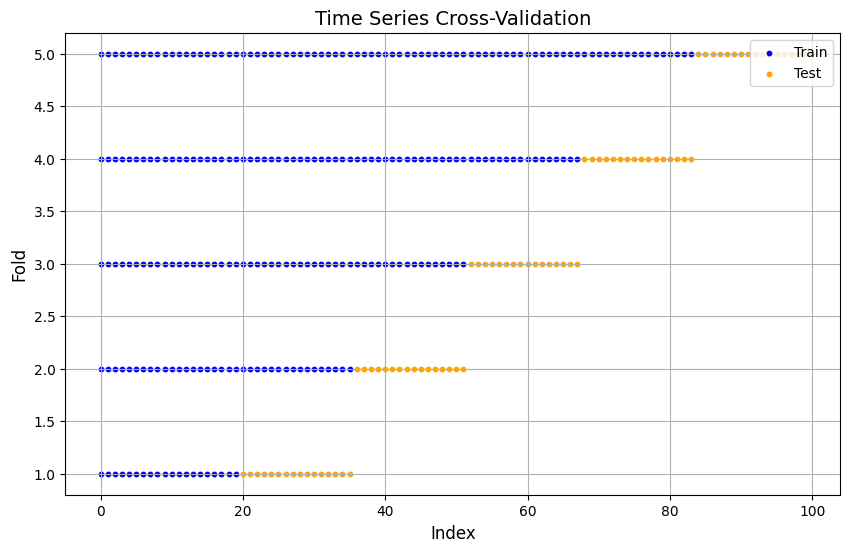

In [19]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [93]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180   # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_ABEV):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


Window 1 Accuracy: 0.6333
Window 2 Accuracy: 0.1889
Window 3 Accuracy: 0.9111
Window 4 Accuracy: 0.5222
Window 5 Accuracy: 0.7778
Window 6 Accuracy: 0.3167
Window 7 Accuracy: 0.5611
Window 8 Accuracy: 0.4222
Window 9 Accuracy: 0.4944
Window 10 Accuracy: 0.8000
Window 11 Accuracy: 0.6722
Window 12 Accuracy: 0.4944
Window 13 Accuracy: 0.7611
Window 14 Accuracy: 0.6222
Window 15 Accuracy: 0.6333
Window 16 Accuracy: 0.6556
Window 17 Accuracy: 0.7667
Window 18 Accuracy: 0.6778
Window 19 Accuracy: 0.5778
Window 20 Accuracy: 0.7556
Window 21 Accuracy: 0.5611
Window 22 Accuracy: 0.5722
Window 23 Accuracy: 0.5833
Window 24 Accuracy: 0.7444
Window 25 Accuracy: 0.7667
Window 26 Accuracy: 0.4278
Window 27 Accuracy: 0.5667
Window 28 Accuracy: 0.7333
Window 29 Accuracy: 0.3833

Walk-Forward Validation with Rolling Windows Results:
Average Accuracy: 0.6063
Standard Deviation: 0.1576


#### Outras métricas de acurácia.

In [21]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.822055,0.580531,0.680498,565.000000
Up Day,0.630841,0.850840,0.724508,476.000000
accuracy,0.704131,0.704131,0.704131,0.704131
macro avg,0.726448,0.715686,0.702503,1041.000000
weighted avg,0.734622,0.704131,0.700622,1041.000000


Accuracy: 0.7041306436119116
Precision: 0.6308411214953271
Recall: 0.8508403361344538
Specificity: 0.5805309734513274


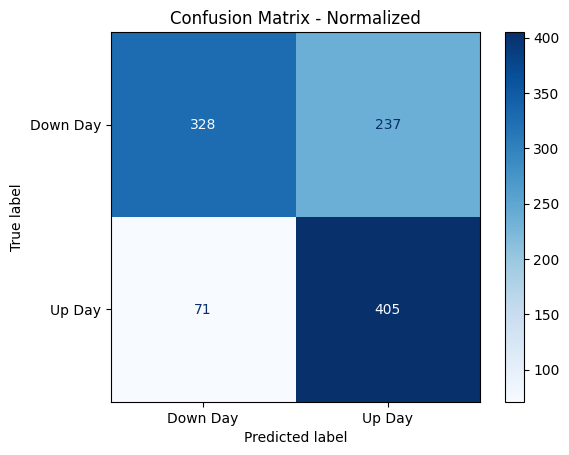

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


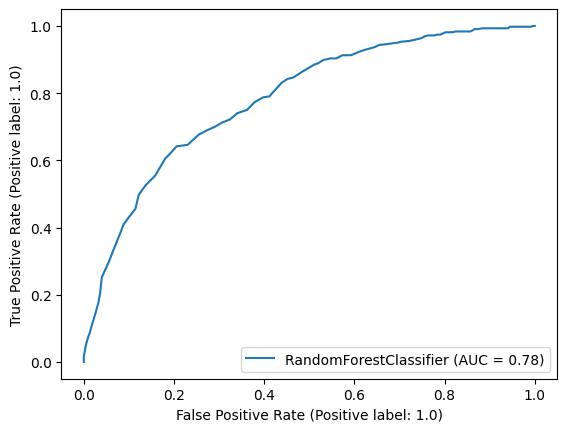

In [56]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para AMBEV.

In [94]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Ambev, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl']

#### Carregar modelo. Geralmente carrego do modelo aprendido geral.

In [98]:
# Carregar o modelo salvo
rand_frst_clf_Ambev = joblib.load('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl')

#### Split normal sem cross-validation.

In [96]:
# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Ambev.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Ambev.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Ambev.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  100.0


In [88]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.741425,0.592827,0.658851,474.000000
Up Day,0.815134,0.896733,0.853989,949.000000
accuracy,0.795502,0.795502,0.795502,0.795502
macro avg,0.778279,0.744780,0.756420,1423.000000
weighted avg,0.790582,0.795502,0.788989,1423.000000


#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [95]:
# Selecionar colunas como array NumPy
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values


price_data_ABEV['Prediction'] = np.NaN
# Gerar previsões e atualizar a coluna 'Prediction'
price_data_ABEV['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols)


price_data_ABEV['Match'] = (price_data_ABEV['Prediction'] == price_data_ABEV['Verify']).astype(int)
accuracy = price_data_ABEV['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 47.50%


In [96]:
from datetime import timedelta

# Filtrar últimos 30 dias
last_30_days = price_data_ABEV[price_data_ABEV['Date'] >= price_data_ABEV['Date'].max() - timedelta(days=30)]

# Selecionar colunas como array NumPy
X_Cols = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction' para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols)

# Comparar valores e calcular a precisão
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = last_30_days['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy:.2%}")



Precisão do modelo nos últimos 30 dias: 52.63%


#### Plotagem:

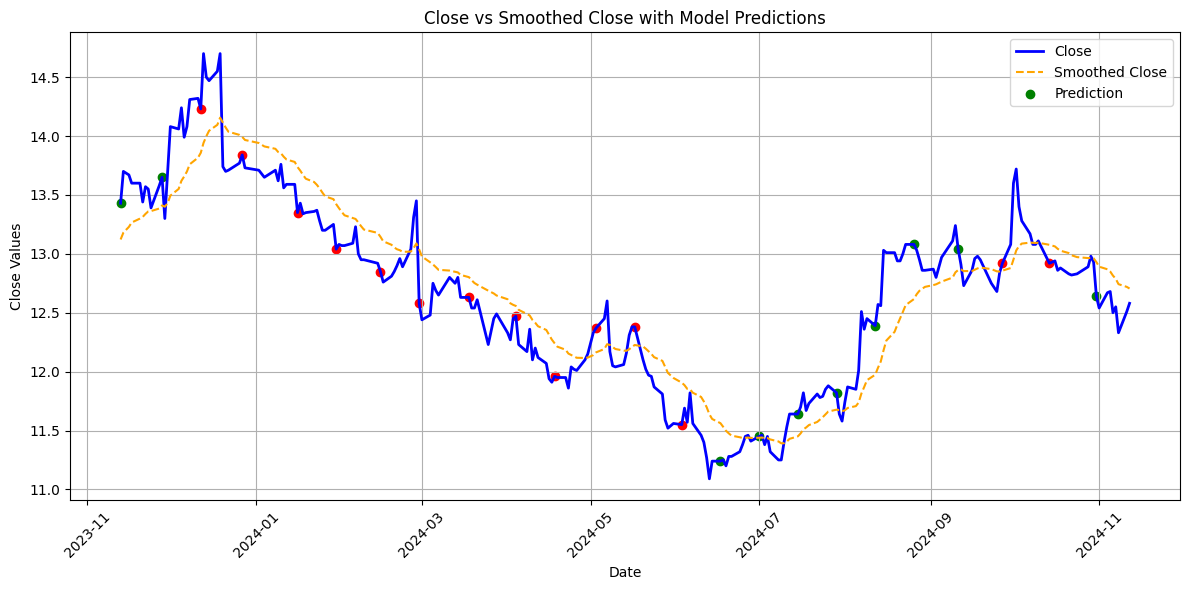

In [97]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ABEV3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### ITAÚ

#### Time series Cross-Validation

In [98]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data_Itau.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
17824,2001-01-12,3.129443,3.129443,3.046653,3.080100,1.690352,49788916,ITUB4.SA,-0.049343,3.039109,-1.0,3.080100,-1.0,2.823122,2.959667,0.049343,0.000000,54.433299,2.790006,3.228790,56.771310,-43.228690,0.011519,0.009805,0.030898,653169644,1
17825,2001-01-15,3.046653,3.112885,3.046653,3.112885,1.708344,7959945,ITUB4.SA,0.032785,3.046487,-1.0,3.112885,-1.0,2.906077,2.954308,0.000000,0.032785,59.382961,2.790006,3.228790,58.452674,-41.547326,0.012869,0.010418,0.032845,661129589,1
17826,2001-01-16,3.112885,3.146001,3.096327,3.129443,1.717432,26138577,ITUB4.SA,0.016558,3.054783,-1.0,3.129443,-1.0,2.996814,2.958559,0.000000,0.016558,61.800980,2.790006,3.228790,60.343261,-39.656739,0.014234,0.011181,0.031102,687268166,1
17827,2001-01-17,3.129443,3.179117,3.104606,3.154280,1.731062,52977726,ITUB4.SA,0.024837,3.064732,1.0,3.154280,-1.0,2.963864,2.959089,0.000000,0.024837,65.369227,2.831401,3.228790,58.716078,-41.283922,0.015714,0.012088,0.028669,740245892,0
17828,2001-01-18,3.154280,3.261906,3.154280,3.261906,1.790126,141660459,ITUB4.SA,0.107626,3.084450,-1.0,3.261906,-1.0,3.013538,2.964534,0.000000,0.107626,76.394363,2.864351,3.261906,55.363083,-44.636917,0.017898,0.013250,0.029533,881906351,1


In [99]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.6307053941908713

Fold 2:
Accuracy for fold 2: 0.5695020746887967

Fold 3:
Accuracy for fold 3: 0.6275933609958506

Fold 4:
Accuracy for fold 4: 0.549792531120332

Fold 5:
Accuracy for fold 5: 0.6566390041493776

                precision    recall  f1-score     support  accuracy
1 Down Day       0.301587  0.057402  0.096447  331.000000  0.630705
  Up Day         0.653718  0.930490  0.767927  633.000000  0.630705
  accuracy       0.630705  0.630705  0.630705    0.630705  0.630705
  macro avg      0.477653  0.493946  0.432187  964.000000  0.630705
  weighted avg   0.532810  0.630705  0.537367  964.000000  0.630705
2 Down Day       0.454701  0.734807  0.561774  362.000000  0.569502
  Up Day         0.746702  0.470100  0.576962  602.000000  0.569502
  accuracy       0.569502  0.569502  0.569502    0.569502  0.569502
  macro avg      0.600701  0.602453  0.569368  964.000000  0.569502
  weighted avg   0.637050  0.569502  0.571259  964.000000  0.569502
3 Down D

#### Plotagem Time-Series Cross Validation

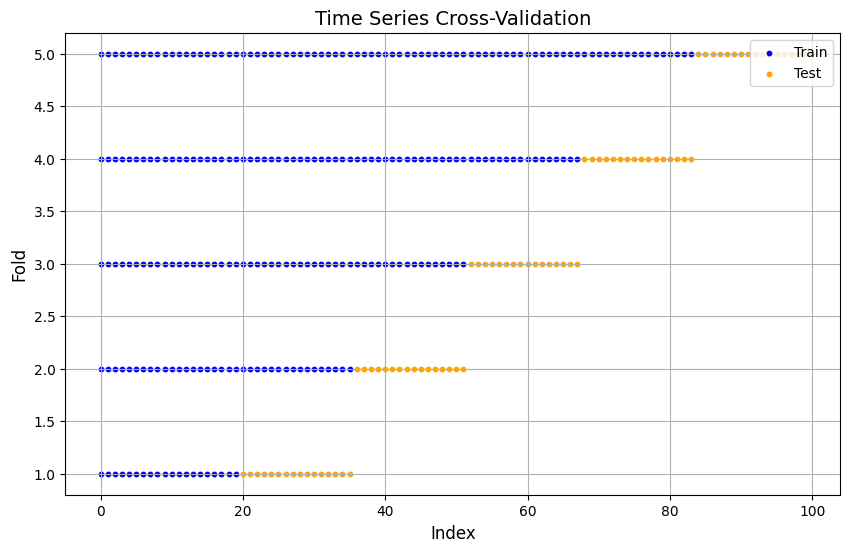

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [100]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Itau):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


Window 1 Accuracy: 0.5444
Window 2 Accuracy: 0.5000
Window 3 Accuracy: 0.3222
Window 4 Accuracy: 0.6722
Window 5 Accuracy: 0.6778
Window 6 Accuracy: 0.8722
Window 7 Accuracy: 0.6056
Window 8 Accuracy: 0.5389
Window 9 Accuracy: 0.4833
Window 10 Accuracy: 0.2833
Window 11 Accuracy: 0.7333
Window 12 Accuracy: 0.4778
Window 13 Accuracy: 0.6778
Window 14 Accuracy: 0.7944
Window 15 Accuracy: 0.5833
Window 16 Accuracy: 0.6778
Window 17 Accuracy: 0.6000
Window 18 Accuracy: 0.5500
Window 19 Accuracy: 0.7222
Window 20 Accuracy: 0.6000
Window 21 Accuracy: 0.6667
Window 22 Accuracy: 0.7389
Window 23 Accuracy: 0.6389
Window 24 Accuracy: 0.6111
Window 25 Accuracy: 0.6222
Window 26 Accuracy: 0.6444
Window 27 Accuracy: 0.6944
Window 28 Accuracy: 0.6667
Window 29 Accuracy: 0.3500
Window 30 Accuracy: 0.6667

Walk-Forward Validation with Rolling Windows Results:
Average Accuracy: 0.6072
Standard Deviation: 0.1291


#### Outras métricas de acurácia.

In [24]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.548214,0.679204,0.606719,452.000000
Up Day,0.641089,0.505859,0.565502,512.000000
accuracy,0.587137,0.587137,0.587137,0.587137
macro avg,0.594652,0.592531,0.586111,964.000000
weighted avg,0.597542,0.587137,0.584828,964.000000


Accuracy: 0.5871369294605809
Precision: 0.6410891089108911
Recall: 0.505859375
Specificity: 0.6792035398230089


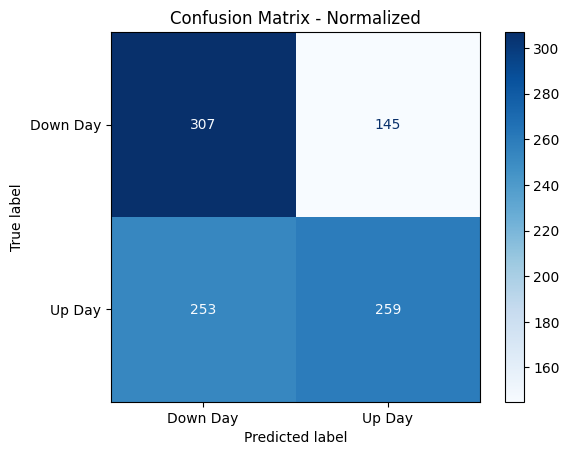

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


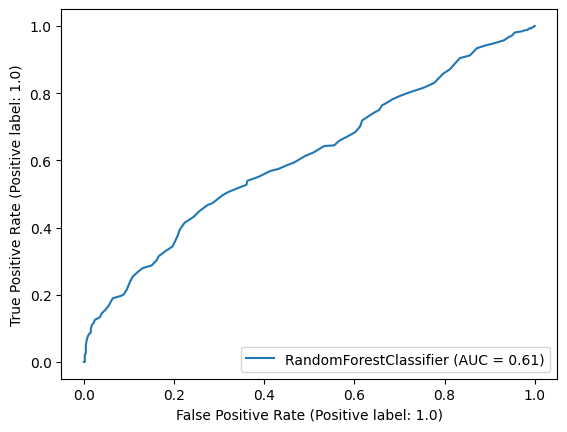

In [27]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Itau, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para ITAU.

In [101]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Itau, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl']

#### Carregar modelo. Geralmente carrego do modelo aprendido geral.

In [36]:
# Carregar o modelo salvo
rand_frst_clf_Itau = joblib.load('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

#### Split normal sem cross-validation.

In [29]:
# Grab our X & Y Columns.
X_Cols = price_data_Itau[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Itau.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Itau.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Itau.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  74.36074637180373


In [30]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.726269,0.571181,0.639456,576.000000
Up Day,0.751509,0.857635,0.801072,871.000000
accuracy,0.743607,0.743607,0.743607,0.743607
macro avg,0.738889,0.714408,0.720264,1447.000000
weighted avg,0.741462,0.743607,0.736738,1447.000000


#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [102]:
import warnings

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Selecionar colunas como array NumPy
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values


price_data_Itau['Prediction'] = np.NaN
# Gerar previsões e atualizar a coluna 'Prediction'
price_data_Itau['Prediction'] = rand_frst_clf_Itau.predict(X_Cols)


price_data_Itau['Match'] = (price_data_Itau['Prediction'] == price_data_Itau['Verify']).astype(int)
accuracy = price_data_Itau['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 59.71%


In [103]:
from datetime import timedelta

# Filtrar últimos 30 dias
last_30_days = price_data_Itau[price_data_Itau['Date'] >= price_data_Itau['Date'].max() - timedelta(days=30)]

# Selecionar colunas como array NumPy
X_Cols = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction' para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Itau.predict(X_Cols)

# Comparar valores e calcular a precisão
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = last_30_days['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy:.2%}")



Precisão do modelo nos últimos 30 dias: 72.73%


#### Plotagem:

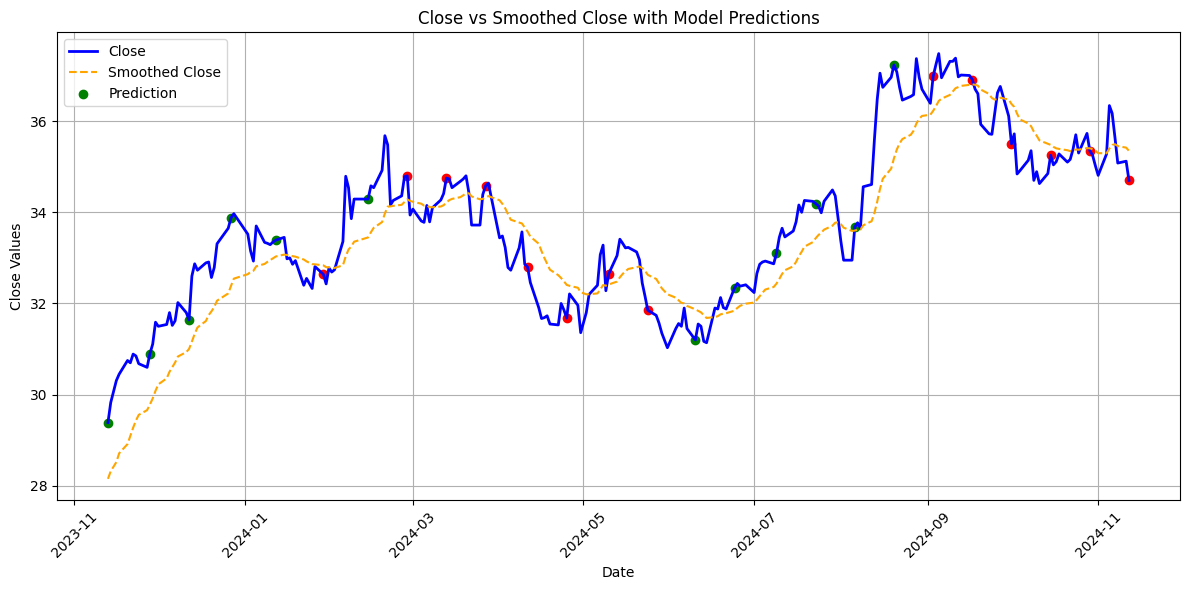

In [104]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ITUB4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### MAGALU

#### Time series Cross-Validation

In [105]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data_Magalu.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
23653,2011-05-23,4.606467,4.641542,4.545086,4.641542,4.274923,935719,MGLU3.SA,-0.017537,4.731706,1.0,4.641542,1.0,4.901678,4.802763,0.017537,0.000000,32.626397,4.533395,4.878295,57.498153,-42.501847,-0.008123,-0.031030,-0.013872,-13212506,1
23654,2011-05-24,4.662002,4.676616,4.533395,4.580161,4.218390,3585840,MGLU3.SA,-0.061381,4.716552,1.0,4.580161,1.0,4.881218,4.810609,0.061381,0.000000,25.316822,4.533395,4.878295,53.104275,-46.895725,-0.010219,-0.026868,-0.015133,-16798346,1
23655,2011-05-25,4.574315,4.574315,4.439862,4.442785,4.091866,1985366,MGLU3.SA,-0.137376,4.689175,-1.0,4.442785,1.0,4.793532,4.808901,0.137376,0.000000,16.037903,4.439862,4.822760,65.112083,-34.887917,-0.013341,-0.024162,-0.020942,-18783712,0
23656,2011-05-26,4.436940,4.603544,4.436940,4.597698,4.234542,1263135,MGLU3.SA,0.154913,4.680027,1.0,4.597698,1.0,4.764303,4.804441,0.000000,0.154913,43.149183,4.436940,4.822760,63.005301,-36.994699,-0.016122,-0.022554,-0.023054,-20046847,1
23657,2011-05-27,4.556778,4.647387,4.536318,4.618158,4.253386,1778037,MGLU3.SA,0.020460,4.673840,1.0,4.618158,-1.0,4.545086,4.778506,0.000000,0.020460,45.815425,4.436940,4.822760,61.401720,-38.598280,-0.018445,-0.021732,-0.024110,-21824884,0


In [106]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Maglu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Maglu.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Maglu.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.7743119266055046

Fold 2:
Accuracy for fold 2: 0.3559633027522936

Fold 3:
Accuracy for fold 3: 0.48440366972477067

Fold 4:
Accuracy for fold 4: 0.41834862385321103

Fold 5:
Accuracy for fold 5: 0.5651376146788991

                precision    recall  f1-score     support  accuracy
1 Down Day       0.871391  0.817734  0.843710  406.000000  0.774312
  Up Day         0.548780  0.647482  0.594059  139.000000  0.774312
  accuracy       0.774312  0.774312  0.774312    0.774312  0.774312
  macro avg      0.710086  0.732608  0.718885  545.000000  0.774312
  weighted avg   0.789111  0.774312  0.780038  545.000000  0.774312
2 Down Day       0.095607  0.973684  0.174118   38.000000  0.355963
  Up Day         0.993671  0.309665  0.472180  507.000000  0.355963
  accuracy       0.355963  0.355963  0.355963    0.355963  0.355963
  macro avg      0.544639  0.641674  0.323149  545.000000  0.355963
  weighted avg   0.931054  0.355963  0.451398  545.000000  0.355963
3 Dow

#### Plotagem Time-Series Cross Validation

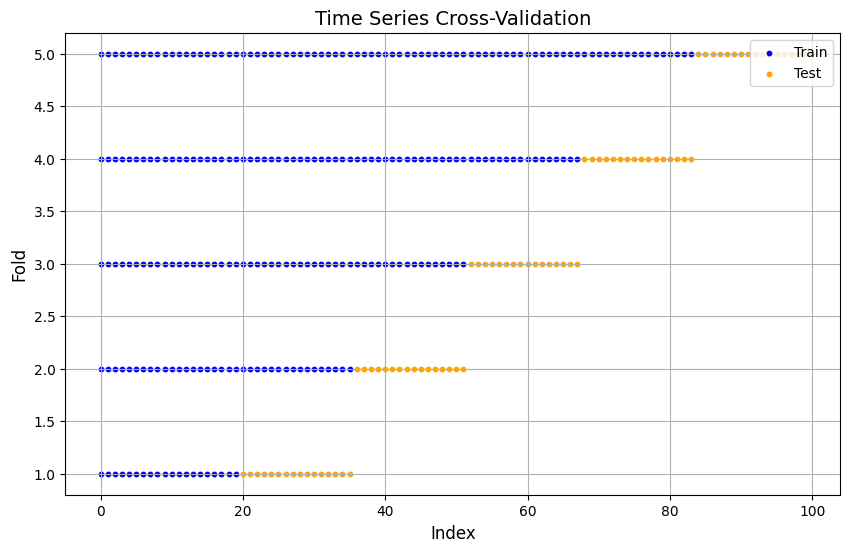

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [107]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Magalu):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Maglu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Maglu.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Maglu.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


Window 1 Accuracy: 0.7500
Window 2 Accuracy: 0.7167
Window 3 Accuracy: 0.7444
Window 4 Accuracy: 0.4222
Window 5 Accuracy: 0.3056
Window 6 Accuracy: 0.9944
Window 7 Accuracy: 0.8000
Window 8 Accuracy: 0.4667
Window 9 Accuracy: 0.6611
Window 10 Accuracy: 0.8500
Window 11 Accuracy: 0.2667
Window 12 Accuracy: 0.4944
Window 13 Accuracy: 0.7278
Window 14 Accuracy: 0.5111
Window 15 Accuracy: 0.3500
Window 16 Accuracy: 0.6611

Walk-Forward Validation with Rolling Windows Results:
Average Accuracy: 0.6076
Standard Deviation: 0.2041


#### Outras métricas de acurácia.

In [ ]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

Accuracy: 0.7041306436119116
Precision: 0.6308411214953271
Recall: 0.8508403361344538
Specificity: 0.5805309734513274


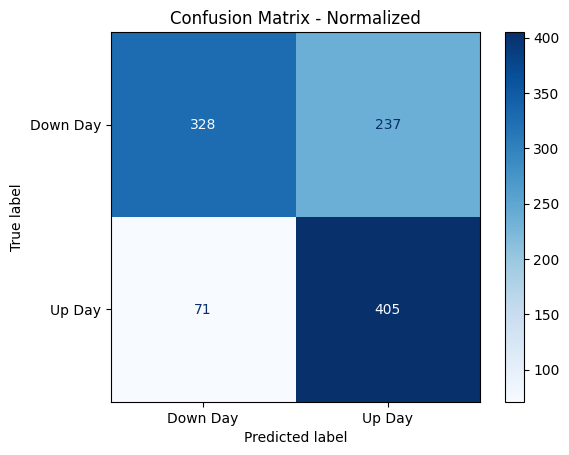

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


In [ ]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Maglu, X_test, y_test)
plt.show()


NameError: name 'RocCurveDisplay' is not defined

#### Salvar modelo aprendido para MAGALU.

In [108]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Maglu, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl']

#### Carregar modelo. Geralmente carrego do modelo aprendido geral.

In [48]:
# Carregar o modelo salvo
rand_frst_clf_Maglu = joblib.load('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

#### Split normal sem cross-validation.

In [109]:
# Grab our X & Y Columns.
X_Cols = price_data_Magalu[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Maglu = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Maglu.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Maglu.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Maglu.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  88.03418803418803


In [45]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.808333,0.765789,0.786486,380.000000
Up Day,0.805677,0.842466,0.823661,438.000000
accuracy,0.806846,0.806846,0.806846,0.806846
macro avg,0.807005,0.804128,0.805074,818.000000
weighted avg,0.806911,0.806846,0.806392,818.000000


#### Utilizando a verificação da predição com o preço real e não suavizado. Manter cross-validation.

In [110]:
import warnings

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Selecionar colunas como array NumPy
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values


price_data_Magalu['Prediction'] = np.NaN
# Gerar previsões e atualizar a coluna 'Prediction'
price_data_Magalu['Prediction'] = rand_frst_clf_Maglu.predict(X_Cols)


price_data_Magalu['Match'] = (price_data_Magalu['Prediction'] == price_data_Magalu['Verify']).astype(int)
accuracy = price_data_Magalu['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 80.20%


In [111]:
from datetime import timedelta

# Filtrar últimos 30 dias
last_30_days = price_data_Magalu[price_data_Magalu['Date'] >= price_data_Magalu['Date'].max() - timedelta(days=30)]

# Selecionar colunas como array NumPy
X_Cols = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction' para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Maglu.predict(X_Cols)

# Comparar valores e calcular a precisão
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = last_30_days['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy:.2%}")



Precisão do modelo nos últimos 30 dias: 95.00%


#### Plotagem:

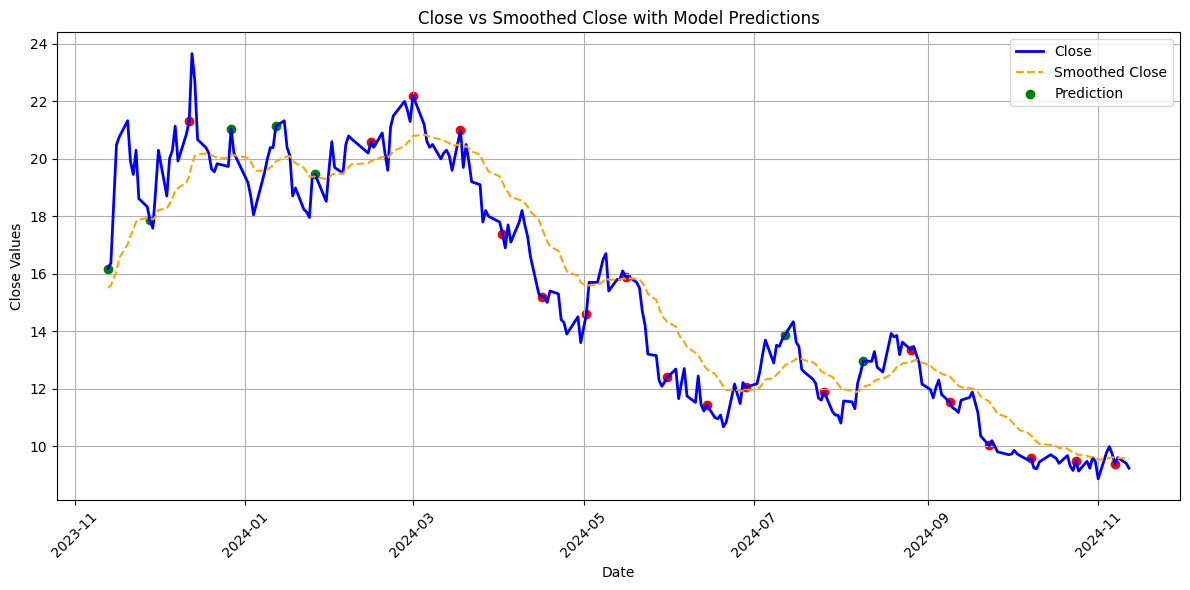

In [112]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'MGLU3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Petrobrás.

#### Time series Cross-Validation

In [113]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data_Petro.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
11761,2000-01-20,5.313,5.313,5.313,5.313,1.159541,26268160000,PETR4.SA,-0.012,5.524186,1.0,5.313,1.0,6.181,5.727694,0.012,0.000,27.170336,5.313,5.875,37.577523,-62.422477,-0.033294,-0.035930,-0.038762,-336407040000,1
11762,2000-01-21,5.200,5.200,5.200,5.200,1.134879,17512960000,PETR4.SA,-0.113,5.491767,1.0,5.200,1.0,6.399,5.794824,0.113,0.000,20.428414,5.200,5.613,70.645841,-29.354159,-0.037668,-0.036277,-0.042170,-353920000000,1
11763,2000-01-24,5.163,5.163,5.163,5.163,1.126804,18385920000,PETR4.SA,-0.037,5.458890,1.0,5.163,1.0,6.213,5.836642,0.037,0.000,18.677468,5.163,5.613,65.753448,-34.246552,-0.042507,-0.037523,-0.043591,-372305920000,1
11764,2000-01-26,5.225,5.225,5.225,5.225,1.140336,25917440000,PETR4.SA,0.062,5.435501,1.0,5.225,1.0,5.813,5.834278,0.000,0.062,30.238440,5.163,5.613,60.555877,-39.444123,-0.047117,-0.039442,-0.043925,-398223360000,1
11765,2000-01-27,5.188,5.188,5.188,5.188,1.132261,38379520000,PETR4.SA,-0.037,5.410751,1.0,5.188,1.0,5.888,5.839650,0.037,0.000,27.542316,5.163,5.613,55.055847,-44.944153,-0.051630,-0.041880,-0.042210,-436602880000,1


In [114]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.6939182452642074

Fold 2:
Accuracy for fold 2: 0.5054835493519442

Fold 3:
Accuracy for fold 3: 0.6121635094715853

Fold 4:
Accuracy for fold 4: 0.6071784646061814

Fold 5:
Accuracy for fold 5: 0.6011964107676969

                precision    recall  f1-score      support  accuracy
1 Down Day       0.438202  0.427007  0.432532   274.000000  0.693918
  Up Day         0.786685  0.794239  0.790444   729.000000  0.693918
  accuracy       0.693918  0.693918  0.693918     0.693918  0.693918
  macro avg      0.612444  0.610623  0.611488  1003.000000  0.693918
  weighted avg   0.691486  0.693918  0.692669  1003.000000  0.693918
2 Down Day       0.677686  0.152134  0.248485   539.000000  0.505484
  Up Day         0.481859  0.915948  0.631501   464.000000  0.505484
  accuracy       0.505484  0.505484  0.505484     0.505484  0.505484
  macro avg      0.579773  0.534041  0.439993  1003.000000  0.505484
  weighted avg   0.587094  0.505484  0.425673  1003.000000  0.505

#### Plotagem Time-Series Cross Validation

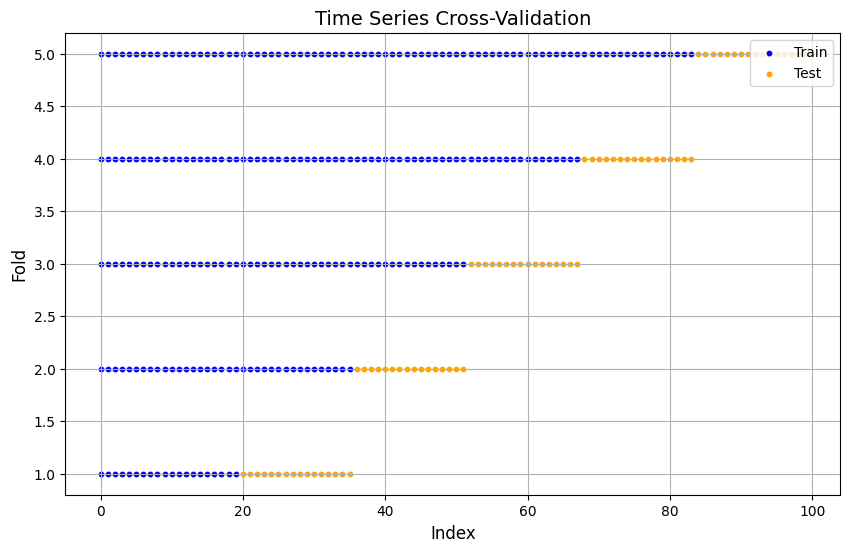

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [115]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Petro):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


Window 1 Accuracy: 0.4389
Window 2 Accuracy: 0.6778
Window 3 Accuracy: 0.4111
Window 4 Accuracy: 0.6944
Window 5 Accuracy: 0.5278
Window 6 Accuracy: 0.6333
Window 7 Accuracy: 0.5944
Window 8 Accuracy: 0.7722
Window 9 Accuracy: 0.4333
Window 10 Accuracy: 0.3000
Window 11 Accuracy: 0.7167
Window 12 Accuracy: 0.7667
Window 13 Accuracy: 0.4611
Window 14 Accuracy: 0.7833
Window 15 Accuracy: 0.6444
Window 16 Accuracy: 0.4722
Window 17 Accuracy: 0.7500
Window 18 Accuracy: 0.3556
Window 19 Accuracy: 0.5944
Window 20 Accuracy: 0.5833
Window 21 Accuracy: 0.6778
Window 22 Accuracy: 0.7333
Window 23 Accuracy: 0.4333
Window 24 Accuracy: 0.4833
Window 25 Accuracy: 0.6556
Window 26 Accuracy: 0.8444
Window 27 Accuracy: 0.6944
Window 28 Accuracy: 0.3667
Window 29 Accuracy: 0.7389
Window 30 Accuracy: 0.7500
Window 31 Accuracy: 0.5278

Walk-Forward Validation with Rolling Windows Results:
Average Accuracy: 0.5973
Standard Deviation: 0.1463


#### Outras métricas de acurácia.

In [61]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.540984,0.525199,0.532974,377.000000
Up Day,0.718995,0.731629,0.725257,626.000000
accuracy,0.654038,0.654038,0.654038,0.654038
macro avg,0.629989,0.628414,0.629116,1003.000000
weighted avg,0.652086,0.654038,0.652983,1003.000000


Accuracy: 0.654037886340977
Precision: 0.7189952904238619
Recall: 0.731629392971246
Specificity: 0.5251989389920424


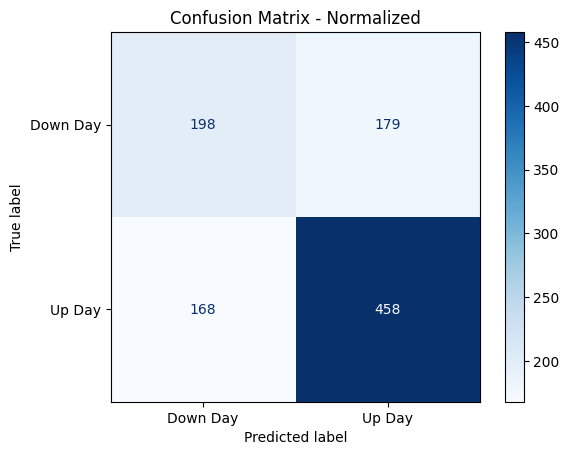

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


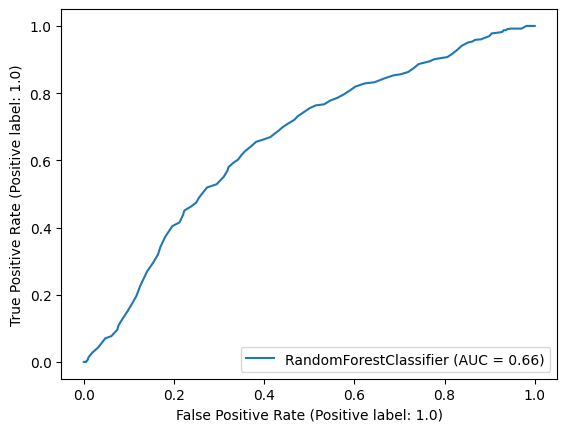

In [63]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Petro, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [116]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Petro, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl']

#### Carregar modelo. Geralmente carrego do modelo aprendido geral.

In [66]:
# Carregar o modelo salvo
rand_frst_clf_Petro = joblib.load('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

#### Split normal sem cross-validation.

In [57]:
# Grab our X & Y Columns.
X_Cols = price_data_Petro[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Petro.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Petro.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Petro.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  79.80066445182725


In [58]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.785110,0.723869,0.753247,641.000000
Up Day,0.806346,0.853009,0.829021,864.000000
accuracy,0.798007,0.798007,0.798007,0.798007
macro avg,0.795728,0.788439,0.791134,1505.000000
weighted avg,0.797301,0.798007,0.796748,1505.000000


#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [117]:
import warnings

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Selecionar colunas como array NumPy
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values


price_data_Petro['Prediction'] = np.NaN
# Gerar previsões e atualizar a coluna 'Prediction'
price_data_Petro['Prediction'] = rand_frst_clf_Petro.predict(X_Cols)


price_data_Petro['Match'] = (price_data_Petro['Prediction'] == price_data_Petro['Verify']).astype(int)
accuracy = price_data_Petro['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 56.76%


In [118]:
from datetime import timedelta

# Filtrar últimos 30 dias
last_30_days = price_data_Petro[price_data_Petro['Date'] >= price_data_Petro['Date'].max() - timedelta(days=30)]

# Selecionar colunas como array NumPy
X_Cols = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction' para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Petro.predict(X_Cols)

# Comparar valores e calcular a precisão
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = last_30_days['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy:.2%}")



Precisão do modelo nos últimos 30 dias: 13.64%


#### Plotagem:

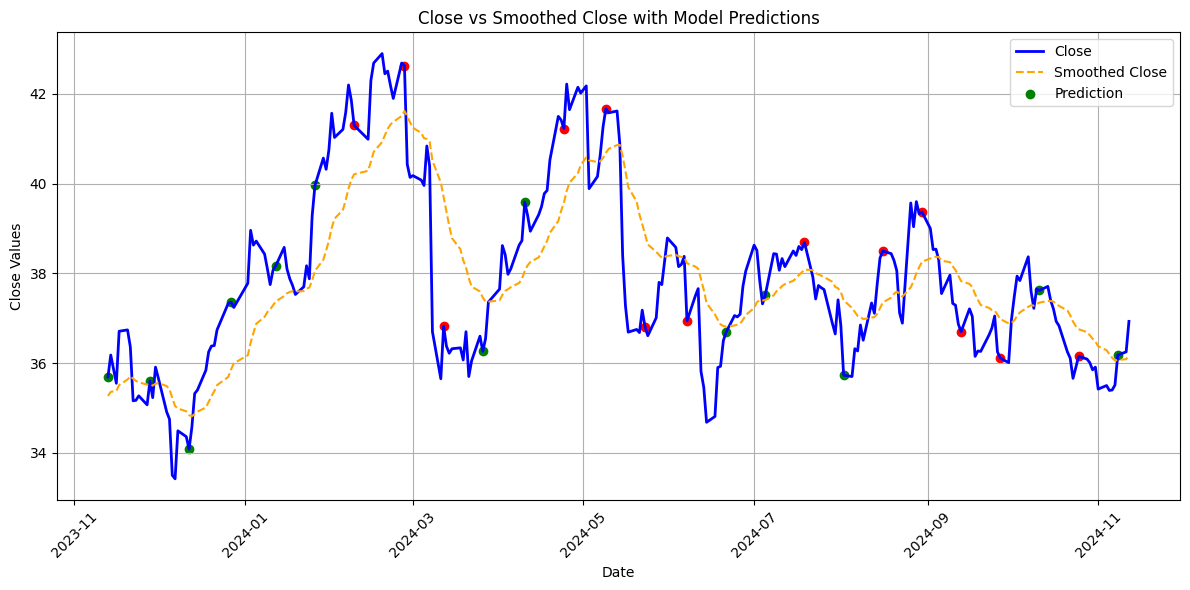

In [119]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'PETR4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Vale.

#### Time series Cross-Validation

In [120]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data_Vale.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_30,Smoothed_Close_30,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
5746,2000-01-21,4.000000,4.000000,3.916666,3.916666,1.666643,144000,VALE3.SA,-0.083334,3.816120,-1.0,3.916666,-1.0,3.024166,3.359315,0.083334,0.000000,55.357618,3.375000,4.166666,55.720498,-44.279502,0.039181,0.037256,0.082815,21388800,1
5747,2000-01-26,3.966666,3.966666,3.966666,3.966666,1.687919,196800,VALE3.SA,0.050000,3.831175,1.0,3.966666,-1.0,2.833333,3.306717,0.000000,0.050000,60.156173,3.375000,4.166666,57.622130,-42.377870,0.042333,0.038272,0.077384,21585600,0
5748,2000-01-28,4.000000,4.000000,4.000000,4.000000,1.702103,211200,VALE3.SA,0.033334,3.848057,-1.0,4.000000,-1.0,2.921666,3.268212,0.000000,0.033334,63.199074,3.375000,4.166666,59.754660,-40.245340,0.045218,0.039661,0.072385,21796800,1
5749,2000-02-01,3.916666,3.916666,3.916666,3.916666,1.666643,148800,VALE3.SA,-0.083334,3.854918,-1.0,3.916666,-1.0,2.975000,3.238891,0.083334,0.000000,51.789901,3.458333,4.166666,55.988524,-44.011476,0.047280,0.041185,0.061868,21945600,1
5750,2000-02-02,3.950000,3.950000,3.750000,3.750000,1.595722,739200,VALE3.SA,-0.166666,3.844426,-1.0,3.750000,-1.0,3.041666,3.219168,0.166666,0.000000,36.559368,3.750000,4.166666,22.662369,-77.337631,0.047618,0.042471,0.045926,21206400,1


In [121]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.5798994974874372

Fold 2:
Accuracy for fold 2: 0.6030150753768844

Fold 3:
Accuracy for fold 3: 0.49246231155778897

Fold 4:
Accuracy for fold 4: 0.592964824120603

Fold 5:
Accuracy for fold 5: 0.6633165829145728

                precision    recall  f1-score     support  accuracy
1 Down Day       0.274834  0.294326  0.284247  282.000000  0.579899
  Up Day         0.712843  0.692847  0.702703  713.000000  0.579899
  accuracy       0.579899  0.579899  0.579899    0.579899  0.579899
  macro avg      0.493839  0.493587  0.493475  995.000000  0.579899
  weighted avg   0.588704  0.579899  0.584105  995.000000  0.579899
2 Down Day       0.671975  0.419483  0.516524  503.000000  0.603015
  Up Day         0.571219  0.790650  0.663257  492.000000  0.603015
  accuracy       0.603015  0.603015  0.603015    0.603015  0.603015
  macro avg      0.621597  0.605067  0.589890  995.000000  0.603015
  weighted avg   0.622154  0.603015  0.589079  995.000000  0.603015
3 Down 

#### Plotagem Time-Series Cross Validation

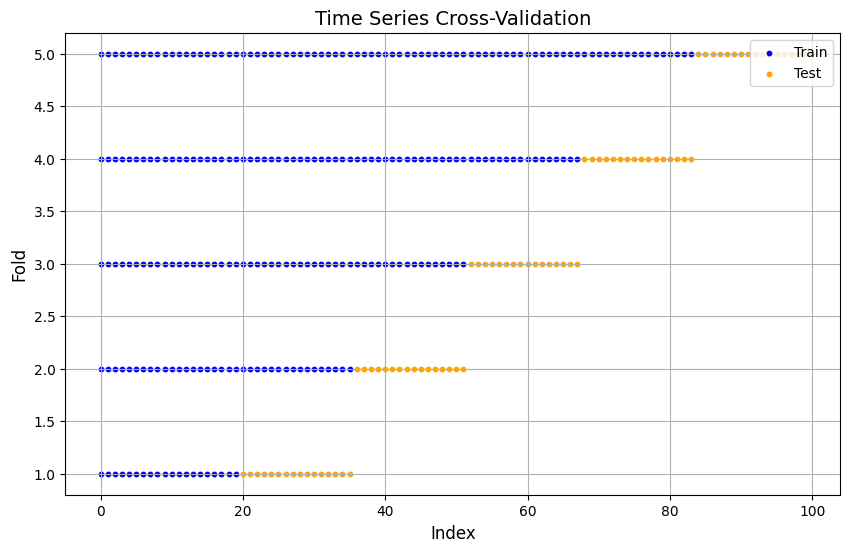

In [54]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [122]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Vale):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


Window 1 Accuracy: 0.3222
Window 2 Accuracy: 0.6056
Window 3 Accuracy: 0.3500
Window 4 Accuracy: 0.4667
Window 5 Accuracy: 0.7333
Window 6 Accuracy: 0.6000
Window 7 Accuracy: 0.6611
Window 8 Accuracy: 0.8778
Window 9 Accuracy: 0.6278
Window 10 Accuracy: 0.7111
Window 11 Accuracy: 0.5833
Window 12 Accuracy: 0.7722
Window 13 Accuracy: 0.6000
Window 14 Accuracy: 0.3722
Window 15 Accuracy: 0.4222
Window 16 Accuracy: 0.4500
Window 17 Accuracy: 0.5111
Window 18 Accuracy: 0.3500
Window 19 Accuracy: 0.6000
Window 20 Accuracy: 0.5056
Window 21 Accuracy: 0.4000
Window 22 Accuracy: 0.6278
Window 23 Accuracy: 0.6167
Window 24 Accuracy: 0.4611
Window 25 Accuracy: 0.6722
Window 26 Accuracy: 0.5056
Window 27 Accuracy: 0.5944
Window 28 Accuracy: 0.7333
Window 29 Accuracy: 0.7389
Window 30 Accuracy: 0.5833
Window 31 Accuracy: 0.4556

Walk-Forward Validation with Rolling Windows Results:
Average Accuracy: 0.5649
Standard Deviation: 0.1367


#### Outras métricas de acurácia.

In [86]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.761324,0.688189,0.722911,635.00000
Up Day,0.784548,0.840326,0.811480,858.00000
accuracy,0.775620,0.775620,0.775620,0.77562
macro avg,0.772936,0.764258,0.767196,1493.00000
weighted avg,0.774671,0.775620,0.773810,1493.00000


Accuracy: 0.7756195579370395
Precision: 0.7845484221980413
Recall: 0.8403263403263403
Specificity: 0.6881889763779527


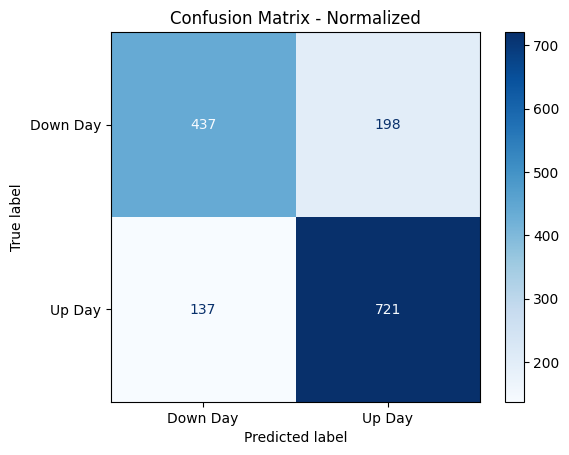

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


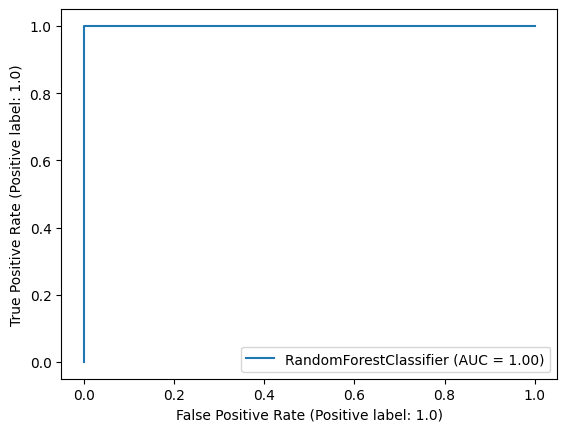

In [84]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Vale, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [123]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Vale, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl']

#### Carregar modelo. Geralmente carrego do modelo aprendido geral.

In [81]:
# Carregar o modelo salvo
rand_frst_clf_Vale = joblib.load('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

#### Split normal sem cross-validation.

In [75]:
# Grab our X & Y Columns.
X_Cols = price_data_Vale[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Vale.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Vale.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Vale.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  77.56195579370396


In [76]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.761324,0.688189,0.722911,635.00000
Up Day,0.784548,0.840326,0.811480,858.00000
accuracy,0.775620,0.775620,0.775620,0.77562
macro avg,0.772936,0.764258,0.767196,1493.00000
weighted avg,0.774671,0.775620,0.773810,1493.00000


#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [124]:
import warnings

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Selecionar colunas como array NumPy
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values


price_data_Vale['Prediction'] = np.NaN
# Gerar previsões e atualizar a coluna 'Prediction'
price_data_Vale['Prediction'] = rand_frst_clf_Vale.predict(X_Cols)


price_data_Vale['Match'] = (price_data_Vale['Prediction'] == price_data_Vale['Verify']).astype(int)
accuracy = price_data_Vale['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 59.95%


In [125]:
from datetime import timedelta

# Filtrar últimos 30 dias
last_30_days = price_data_Vale[price_data_Vale['Date'] >= price_data_Vale['Date'].max() - timedelta(days=30)]

# Selecionar colunas como array NumPy
X_Cols = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction' para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Vale.predict(X_Cols)

# Comparar valores e calcular a precisão
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = last_30_days['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy:.2%}")



Precisão do modelo nos últimos 30 dias: 4.55%


#### Plotagem:

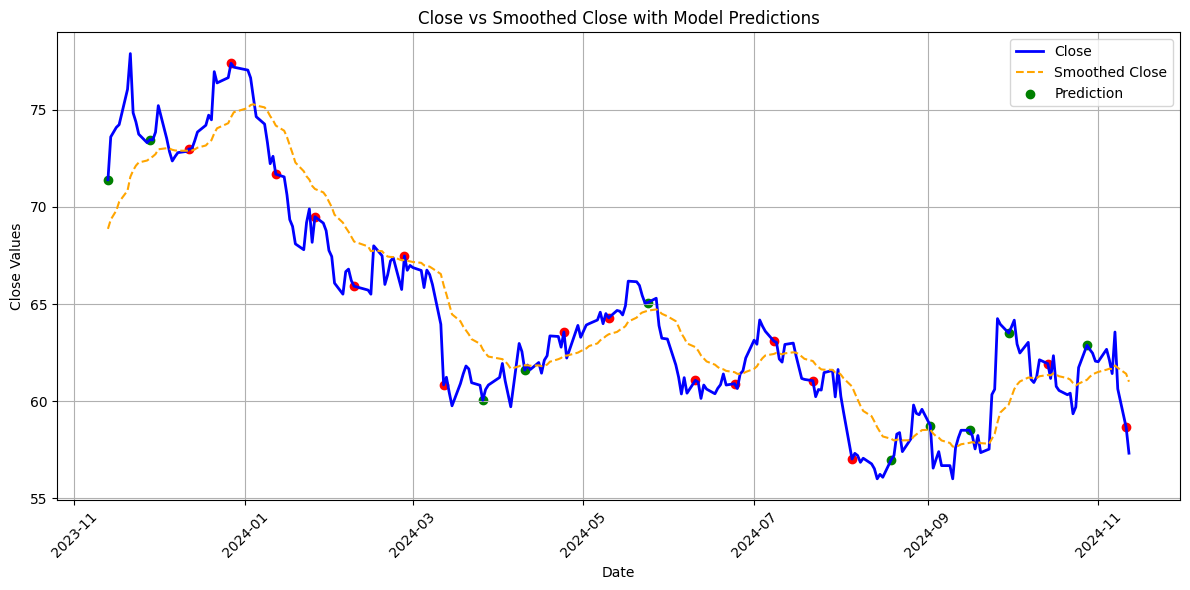

In [126]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Old.

In [21]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

In [22]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  80.19632949210414


In [23]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.787940,0.752264,0.769689,3092.000000
Up Day,0.812117,0.840996,0.826304,3937.000000
accuracy,0.801963,0.801963,0.801963,0.801963
macro avg,0.800029,0.796630,0.797996,7029.000000
weighted avg,0.801482,0.801963,0.801399,7029.000000


Accuracy: 0.8019632949210413
Precision: 0.8121167525141035
Recall: 0.840995681991364
Specificity: 0.7522639068564037


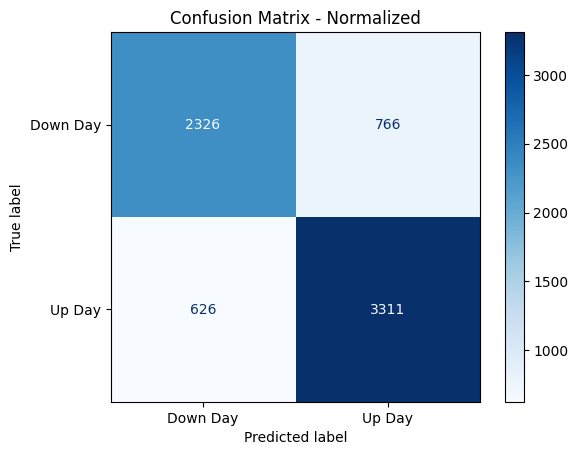

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


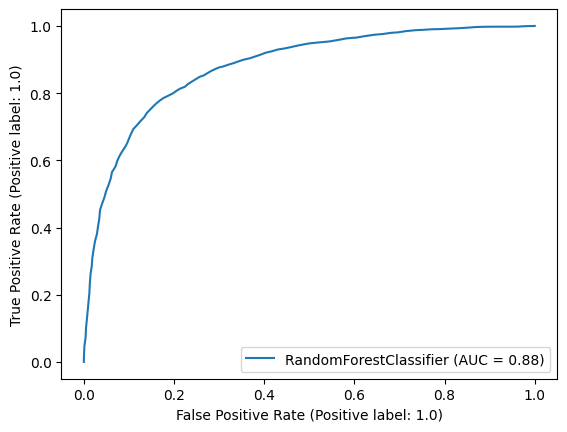

In [25]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf, X_test, y_test)
plt.show()


### Plotagem da suavição e indicador de direção da Vale. Dados reais, sem machine learning.

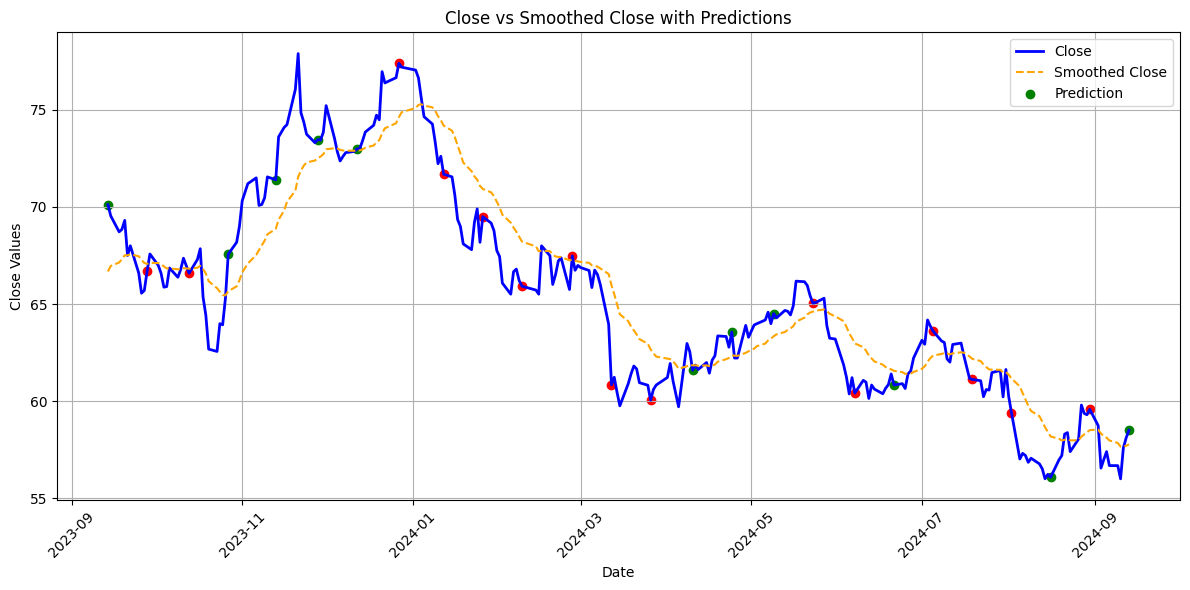

In [195]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar os dados para o Ticker 'VALE3.SA'
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction']]

# Converter a coluna 'Date' para formato datetime, caso necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar os dados para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Configurando o gráfico
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if one_year_data["Prediction"].iloc[i] == 1 else "red"
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Plotagem da suavição e indicador de direção da Ambev. Dados reais, sem machine learning.

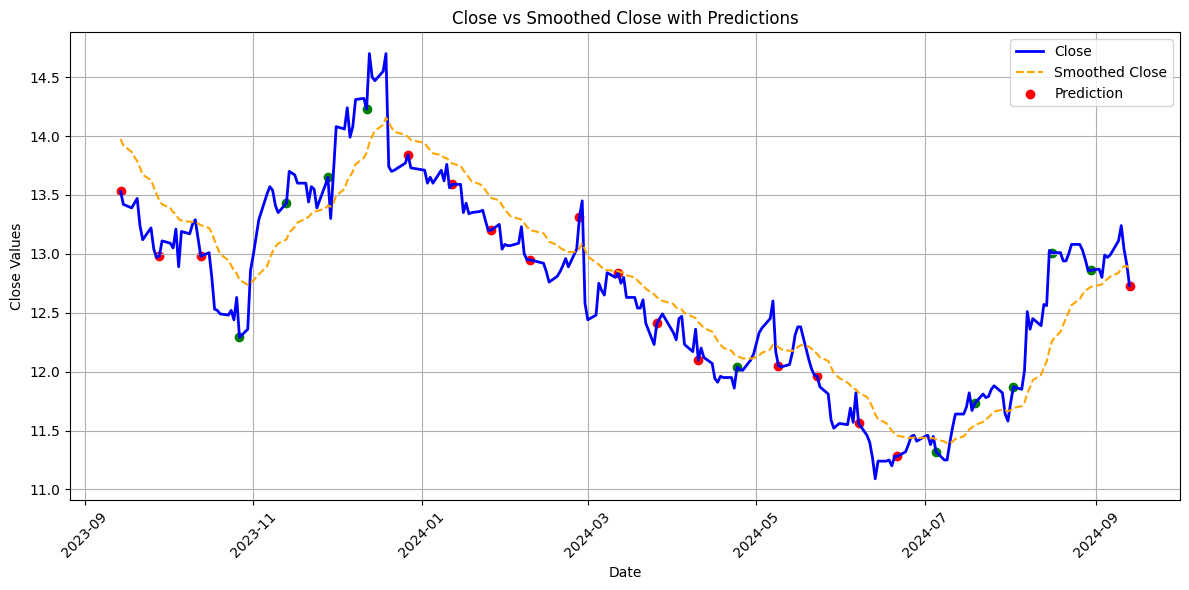

In [197]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar os dados para o Ticker 'VALE3.SA'
ticker_data = price_data[price_data['Ticker'] == 'ABEV3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction']]

# Converter a coluna 'Date' para formato datetime, caso necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar os dados para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Configurando o gráfico
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if one_year_data["Prediction"].iloc[i] == 1 else "red"
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Plotagem da suavição e indicador de direção da Sabesp. Dados reais, sem machine learning.

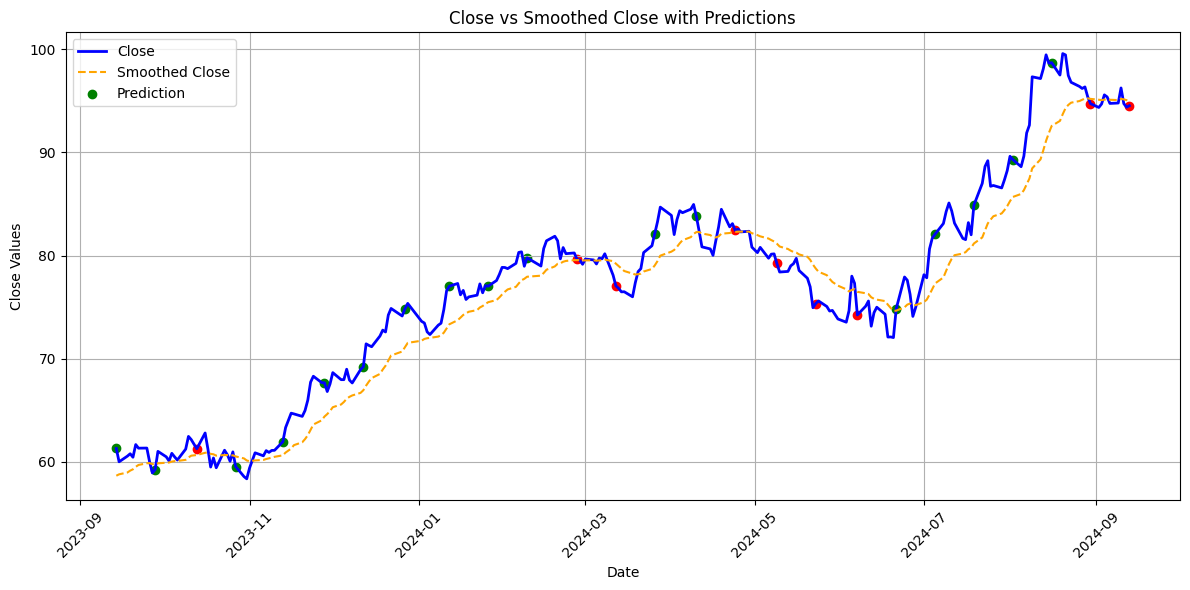

In [198]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar os dados para o Ticker 'VALE3.SA'
ticker_data = price_data[price_data['Ticker'] == 'SBSP3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction']]

# Converter a coluna 'Date' para formato datetime, caso necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar os dados para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Configurando o gráfico
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if one_year_data["Prediction"].iloc[i] == 1 else "red"
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Plotagem do gráfico de Vale com predição do modelo de machine learning.

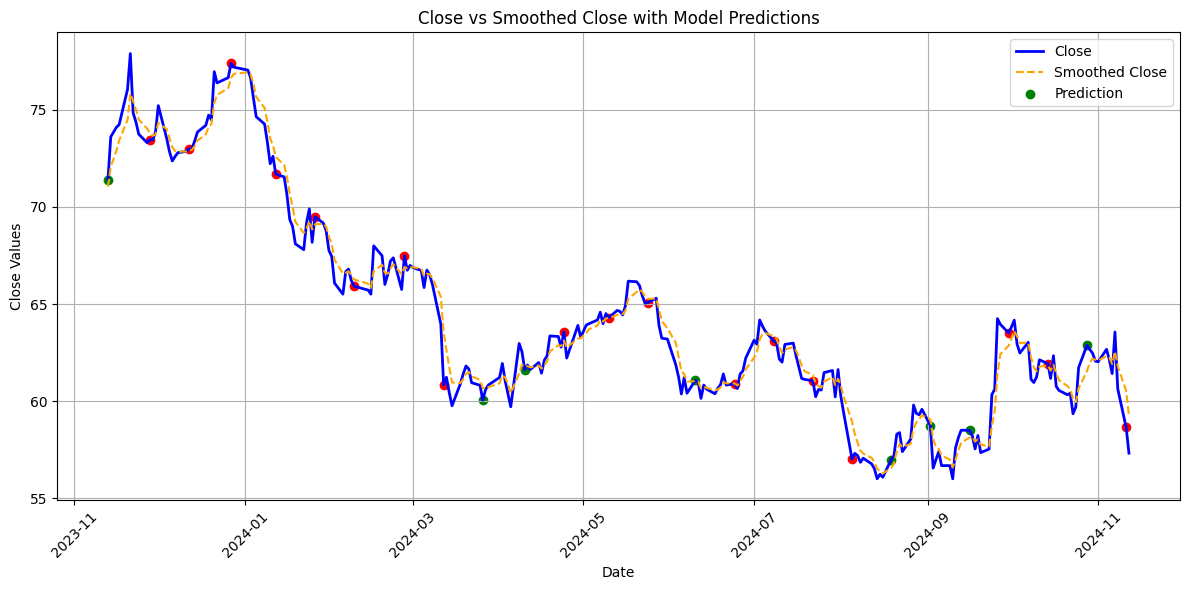

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()
